# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

### Цель лабораторной работы:

Изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

### Задание:


1) Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2) С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3) Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4) Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
5) Сравните метрики качества исходной и оптимальной моделей.


## 1) Выберите набор данных (датасет) для решения задачи классификации или регрессии.    

### Импорт библиотек

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from io import StringIO
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV



%matplotlib inline 
sns.set(style="ticks")

# скроем предупреждения о возможных ошибках для лучшей читаемости
import warnings
warnings.filterwarnings('ignore')

### Смотрим на датасет

In [14]:
data = pd.read_csv('./diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [15]:
df = data.sample(n=2000)

In [16]:
df['Diabetes_binary'].value_counts()

0.0    1007
1.0     993
Name: Diabetes_binary, dtype: int64

In [17]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
55527,1.0,1.0,0.0,1.0,36.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,9.0,4.0,6.0
33407,0.0,0.0,0.0,1.0,22.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,6.0,8.0
65950,1.0,1.0,0.0,1.0,38.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,2.0,0.0,0.0,0.0,1.0,7.0,6.0,8.0
40682,1.0,1.0,1.0,1.0,49.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,4.0,2.0,10.0,0.0,0.0,7.0,6.0,6.0
61329,1.0,1.0,1.0,1.0,42.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,2.0,1.0


In [18]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.496500,0.539000,0.517500,0.975000,29.773500,0.450500,0.056000,0.151000,0.710500,0.635000,...,0.959500,0.091500,2.843500,3.486000,5.349500,0.25200,0.453000,8.552500,4.935500,5.793000
std,0.500113,0.498601,0.499819,0.156164,7.329465,0.497668,0.229979,0.358138,0.453644,0.481551,...,0.197178,0.288391,1.105269,7.862806,9.619648,0.43427,0.497911,2.857153,1.039654,2.185758
min,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,7.000000,4.000000,4.000000
50%,0.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,2.000000,5.000000,1.00000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,84.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.00000,1.000000,13.000000,6.000000,8.000000


In [19]:
print("Размер набора:")
print(f'В датасете {df.shape[0]} строк и {df.shape[1]} колонок.')

Размер набора:
В датасете 2000 строк и 22 колонок.


In [20]:
df.dtypes

Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

In [21]:
df = df.astype('int')
df.dtypes

Diabetes_binary         int64
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object

## 2) С использованием метода train_test_split разделите выборку на обучающую и тестовую.

In [26]:
X = df.drop('Diabetes_binary', axis=1)
Y = df['Diabetes_binary']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
print('{}, {}'.format(X_train.shape, X_test.shape))
print('{}, {}'.format(Y_train.shape, Y_test.shape))

(1400, 21), (600, 21)
(1400,), (600,)


In [29]:
KNC = KNeighborsClassifier(n_neighbors=5)
KNC.fit(X_train, Y_train)

KNeighborsClassifier()

In [38]:
My_KNN_target_1_0 = KNC.predict(X_train)
My_KNN_Y_Pred = KNC.predict(X_test)
print('Accuracy:',accuracy_score(Y_train,My_KNN_target_1_0), accuracy_score(Y_test,My_KNN_Y_Pred))
print('Precision:',precision_score(Y_train,My_KNN_target_1_0), precision_score(Y_test,My_KNN_Y_Pred))
print('F1:',f1_score(Y_train,My_KNN_target_1_0), f1_score(Y_test,My_KNN_Y_Pred))
print('Recall:',recall_score(Y_train,My_KNN_target_1_0), recall_score(Y_test,My_KNN_Y_Pred))

accuracy_score: 0.7885714285714286 0.6866666666666666
precision_score: 0.7794729542302358 0.6766666666666666
f1_score: 0.7915492957746478 0.6835016835016835
recall_score: 0.804005722460658 0.6904761904761905


In [51]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), X, Y, cv=4, scoring='accuracy')
scores

array([0.65 , 0.664, 0.634, 0.646])

In [52]:
np.mean(scores)

0.6485

In [53]:
KN_range_list = list(range(0,150,1))
KN_range_list[0] = 1

In [55]:
second_grid = GridSearchCV(KNeighborsClassifier(),param_grid = [{'n_neighbors':KN_range_list}], scoring = 'accuracy',cv=5, return_train_score=True)
second_grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12, 13, 14, 15, 16, 17, 18, 19, 20,
                                          21, 22, 23, 24, 25, 26, 27, 28, 29, ...]}],
             return_train_score=True, scoring='accuracy')

In [56]:
second_grid.best_params_

{'n_neighbors': 134}

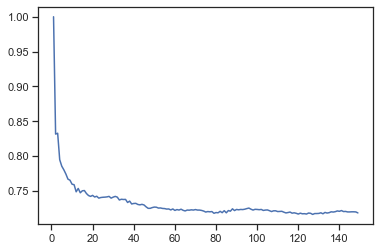

In [57]:
plt.plot(KN_range_list, second_grid.cv_results_["mean_train_score"]);

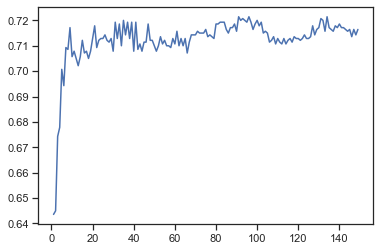

In [58]:


plt.plot(KN_range_list, second_grid.cv_results_["mean_test_score"]);



Accuracy: 0.7185714285714285 0.7266666666666667
Precision: 0.7030625832223701 0.7226027397260274
Recall: 0.7553648068669528 0.717687074829932
F1: 0.7282758620689656 0.720136518771331


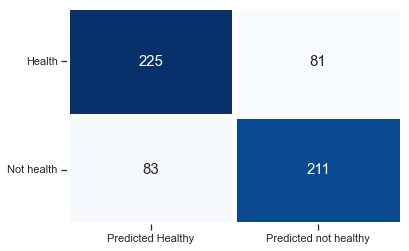

In [67]:
KNN_Searched = KNeighborsClassifier(n_neighbors=134)
KNN_Searched.fit(X_train, Y_train)
KNN_Searched_target_1 = KNN_Searched.predict(X_train)
Y_KNN_Searched_Pred= KNN_Searched.predict(X_test)

print(f'Accuracy:',accuracy_score(Y_train,KNN_Searched_target_1),accuracy_score(Y_test,Y_KNN_Searched_Pred))
print(f'Precision:',precision_score(Y_train,KNN_Searched_target_1),precision_score(Y_test, Y_KNN_Searched_Pred))
print(f'Recall:',recall_score(Y_train,KNN_Searched_target_1),recall_score(Y_test,Y_KNN_Searched_Pred))
print(f'F1:',f1_score(Y_train,KNN_Searched_target_1),f1_score(Y_test,Y_KNN_Searched_Pred))
cm = confusion_matrix(Y_test, Y_KNN_Searched_Pred)
sns.heatmap(cm,cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
    yticklabels = ['Health', 'Not health'], xticklabels = ['Predicted Healthy', 'Predicted not healthy'])
plt.yticks(rotation = 0)
plt.show()